## Setup and Data Import

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from sqlmodel import Session, select

from rs_graph.db import models as db_models
from rs_graph.db.utils import get_engine

plt.style.use("opinionated_rc")

Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

In [2]:
# get a dataset of linked repos and papers
linked_doc_repos: list[dict[str, str | float | int | None]] = []
repo_contributors: list[dict[str, str | float | int | None]] = []
doc_contributors: list[dict[str, str | float | int | None]] = []
matched_contributors: list[dict[str, str | float | int | None]] = []
doc_fields: list[dict[str, str | float | int | None]] = []
engine = get_engine(prod=True)
with Session(engine) as session:
    # Get linked docs repos
    doc_repo_statement = (
        select(
            db_models.Document,
            db_models.Repository,
        )
        .join(
            db_models.DocumentRepositoryLink,
            db_models.DocumentRepositoryLink.document_id == db_models.Document.id,
        )
        .join(
            db_models.Repository,
            db_models.DocumentRepositoryLink.repository_id == db_models.Repository.id,
        )
        .join(
            db_models.DatasetSource,
            db_models.DocumentRepositoryLink.dataset_source_id
            == db_models.DatasetSource.id,
        )
        .where(db_models.DatasetSource.name == "plos")
    )

    # For each one, we need to get count of contributors for document and repository
    for doc, repo in session.exec(doc_repo_statement):
        linked_doc_repos.append(
            {
                "document_id": doc.id,
                "document_publication_date": doc.publication_date,
                "document_cited_by_count": doc.cited_by_count,
                "repository_id": repo.id,
                "repository_forks_count": repo.forks_count,
                "repository_stargazers_count": repo.stargazers_count,
                "repository_watchers_count": repo.watchers_count,
                "repository_open_issues_count": repo.open_issues_count,
                "repository_size_kb": repo.size_kb,
                "repository_creation_datetime": repo.creation_datetime,
                "repository_last_pushed_datetime": repo.last_pushed_datetime,
            }
        )

    # Get all repo contributors
    repo_contributors_statement = (
        select(
            db_models.Repository,
            db_models.DeveloperAccount,
        )
        .join(
            db_models.RepositoryContributor,
            db_models.RepositoryContributor.repository_id == db_models.Repository.id,
        )
        .join(
            db_models.DeveloperAccount,
            db_models.RepositoryContributor.developer_account_id
            == db_models.DeveloperAccount.id,
        )
    )

    for repo, dev in session.exec(repo_contributors_statement):
        repo_contributors.append(
            {
                "repository_id": repo.id,
                "developer_account_id": dev.id,
                "developer_account_username": dev.username,
                "developer_name": dev.name,
                "developer_email": dev.email,
            }
        )

    # Get all doc contributors
    doc_contributors_statement = (
        select(
            db_models.Document,
            db_models.DocumentContributor,
            db_models.Researcher,
        )
        .join(
            db_models.DocumentContributor,
            db_models.DocumentContributor.document_id == db_models.Document.id,
        )
        .join(
            db_models.Researcher,
            db_models.DocumentContributor.researcher_id == db_models.Researcher.id,
        )
    )

    for doc, doc_contributor, researcher in session.exec(doc_contributors_statement):
        doc_contributors.append(
            {
                "document_id": doc.id,
                "researcher_id": researcher.id,
                "researcher_name": researcher.name,
                "researcher_works_count": researcher.works_count,
                "researcher_cited_by_count": researcher.cited_by_count,
                "researcher_h_index": researcher.h_index,
                "researcher_i10_index": researcher.i10_index,
                "researcher_two_year_mean_citedness": researcher.two_year_mean_citedness,
                "document_researcher_position": doc_contributor.position,
                "document_researcher_is_corresponding": doc_contributor.is_corresponding,
            }
        )

    # Get all matched contributors
    matched_contributors_statement = (
        select(
            db_models.DeveloperAccount,
            db_models.Researcher,
        )
        .join(
            db_models.ResearcherDeveloperAccountLink,
            db_models.ResearcherDeveloperAccountLink.developer_account_id
            == db_models.DeveloperAccount.id,
        )
        .join(
            db_models.Researcher,
            db_models.ResearcherDeveloperAccountLink.researcher_id
            == db_models.Researcher.id,
        )
    )

    for dev, researcher in session.exec(matched_contributors_statement):
        matched_contributors.append(
            {
                "developer_account_id": dev.id,
                "researcher_id": researcher.id,
            }
        )

    # Get all doc topics
    doc_topics_statement = (
        select(
            db_models.Document,
            db_models.Topic,
        )
        .join(
            db_models.DocumentTopic,
            db_models.DocumentTopic.document_id == db_models.Document.id,
        )
        .join(
            db_models.Topic,
            db_models.DocumentTopic.topic_id == db_models.Topic.id,
        )
    )

    for doc, topic in session.exec(doc_topics_statement):
        doc_fields.append(
            {
                "document_id": doc.id,
                "topic_id": topic.id,
                "topic_field_name": topic.domain_name,
            }
        )

linked_doc_repos_df = pd.DataFrame(linked_doc_repos)
repo_contributors_df = pd.DataFrame(repo_contributors)
doc_contributors_df = pd.DataFrame(doc_contributors)
matched_contributors_df = pd.DataFrame(matched_contributors)
doc_fields_df = pd.DataFrame(doc_fields)

# Drop any papers that were published before 2015 and after 2023
linked_doc_repos_df["document_publication_year"] = pd.to_datetime(
    linked_doc_repos_df["document_publication_date"]
).dt.year
linked_doc_repos_df = linked_doc_repos_df[
    (linked_doc_repos_df["document_publication_year"] >= 2016)
    & (linked_doc_repos_df["document_publication_year"] < 2024)
]

## Author-Developer Collaboration Patterns

### Authorship and Contributorship

N linked doc-repo pairs: 5201


,mean,std,min,25%,50%,75%,max
Article Authors,5.492982e+00,3.936808,1.000000,3.000000,4.000000,7.000000,44.000000
Repository Contributors,1.909440e+00,3.361958,1.000000,1.000000,1.000000,2.000000,30.000000
Matched Author-Contributors,1.068064e+00,0.916715,0.000000,1.000000,1.000000,1.000000,17.000000
Non-Credited Repository Contributors,8.413767e-01,3.130499,0.000000,0.000000,0.000000,1.000000,30.000000
Total Team Size,6.334359e+00,5.065448,1.000000,3.000000,5.000000,7.000000,46.000000
Document Citations,2.044107e+01,58.307514,0.000000,2.000000,8.000000,19.000000,1634.000000
Mean Normalized Document Citations,-8.880076e-18,0.996629,-1.375856,-0.491545,-0.279804,0.110072,14.442893


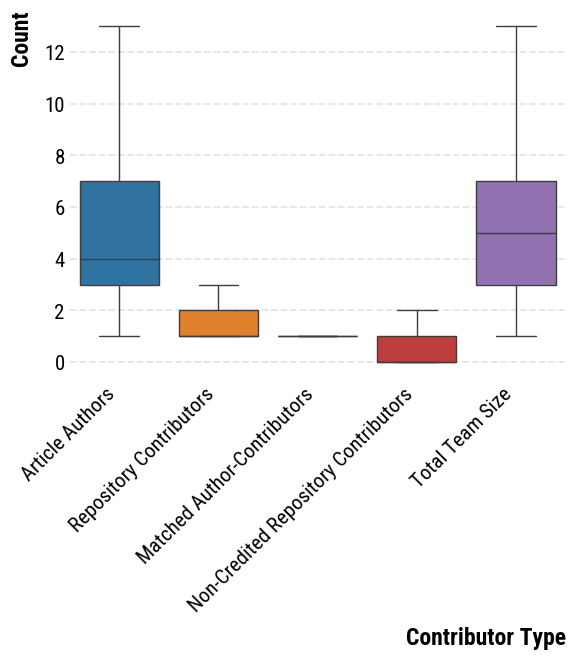

In [3]:
# Create a dataframe of:
# "document_id",
# "Subject",
# "Year",
# "Number of Code-Contributors",
# "Number of Non-Code-Contributors",
# "Number of Matched Contributors",
# "Number of Non-Credited Contributors",
# "Number of Total Contributors",
per_paper_counts = []
for _, row in linked_doc_repos_df.iterrows():
    # Get subject
    subject = doc_fields_df.loc[
        doc_fields_df["document_id"] == row["document_id"]
    ].iloc[0]["topic_field_name"]

    # Get matching doc contributors
    doc_contributors = doc_contributors_df.loc[
        doc_contributors_df["document_id"] == row["document_id"]
    ]

    # Get matching repo contributors
    repo_contributors = repo_contributors_df.loc[
        repo_contributors_df["repository_id"] == row["repository_id"]
    ]

    # Get matching matched contributors
    matched_contributors = matched_contributors_df.loc[
        (
            matched_contributors_df["researcher_id"].isin(
                doc_contributors["researcher_id"]
            )
        )
        & (
            matched_contributors_df["developer_account_id"].isin(
                repo_contributors["developer_account_id"]
            )
        )
    ]

    # Get non-credited contributors
    non_credited_contributors = len(repo_contributors) - len(matched_contributors)

    # Get total contributors
    total_contributors = len(doc_contributors) + non_credited_contributors

    if any(
        [
            len(doc_contributors) == 0,
            len(repo_contributors) == 0,
            non_credited_contributors < 0,
        ]
    ):
        continue

    per_paper_counts.append(
        {
            "document_id": row["document_id"],
            "Subject": subject,
            "Year": row["document_publication_year"],
            "Article Authors": len(doc_contributors),
            "Repository Contributors": len(repo_contributors),
            "Matched Author-Contributors": len(matched_contributors),
            "Non-Credited Repository Contributors": non_credited_contributors,
            "Total Team Size": total_contributors,
            "Document Citations": row["document_cited_by_count"],
        }
    )

# Convert to dataframe
per_paper_counts_df = pd.DataFrame(per_paper_counts)

# Create a column for mean normalized document citations
# Groupby Subject and Year
per_paper_counts_df["Mean Normalized Document Citations"] = per_paper_counts_df.groupby(
    ["Subject", "Year"]
)["Document Citations"].transform(lambda x: (x - x.mean()) / x.std())

# Melt the dataframe to long format
per_paper_counts_long_df = per_paper_counts_df.melt(
    id_vars=[
        "document_id",
        "Subject",
        "Year",
        "Document Citations",
        "Mean Normalized Document Citations",
    ],
    value_vars=[
        "Article Authors",
        "Repository Contributors",
        "Matched Author-Contributors",
        "Non-Credited Repository Contributors",
        "Total Team Size",
    ],
    var_name="Contributor Type",
    value_name="Count",
)

# Plot violinplots
sns.boxplot(
    data=per_paper_counts_long_df,
    x="Contributor Type",
    y="Count",
    hue="Contributor Type",
    hue_order=[
        "Article Authors",
        "Repository Contributors",
        "Matched Author-Contributors",
        "Non-Credited Repository Contributors",
        "Total Team Size",
    ],
    showfliers=False,
)
_ = plt.xticks(rotation=45, ha="right")

print(f"N linked doc-repo pairs: {len(per_paper_counts_df)}")
# Remove "count" from describe
per_paper_counts_df.drop(columns=["document_id", "Subject", "Year"]).describe().T.drop(
    columns=["count"]
)

/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_38266/794341665.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  per_paper_counts_df.groupby("Subject").describe().reset_index().drop(columns=["document_id"]).T


0              1  \
Subject                                   Health Sciences  Life Sciences   
Year                               count            707.0         2369.0   
                                   mean       2020.735502    2020.331786   
                                   std           2.041891       2.262654   
                                   min             2015.0         2015.0   
...                                                   ...            ...   
Mean Normalized Document Citations min          -1.375856      -0.827272   
                                   25%           -0.49421      -0.503189   
                                   50%          -0.321388      -0.271608   
                                   75%            0.13947        0.11166   
                                   max           6.248202      11.751106   

                                                          2                3  
Subject                                   Physical Sciences  Social Sciences  
Year                               count             1613.0            512.0  
                                   mean         2020.518289      2020.679688  
                                   std             2.202907           2.0822  
                                   min               2015.0           2015.0  
...                                                     ...              ...  
Mean Normalized Document Citations min            -0.940821        -1.239596  
                                   25%            -0.457129        -0.385198  
                                   50%            -0.284977         -0.27163  
                                   75%             0.099053         0.037487  
                                   max            14.442893         7.629471  

[65 rows x 4 columns]

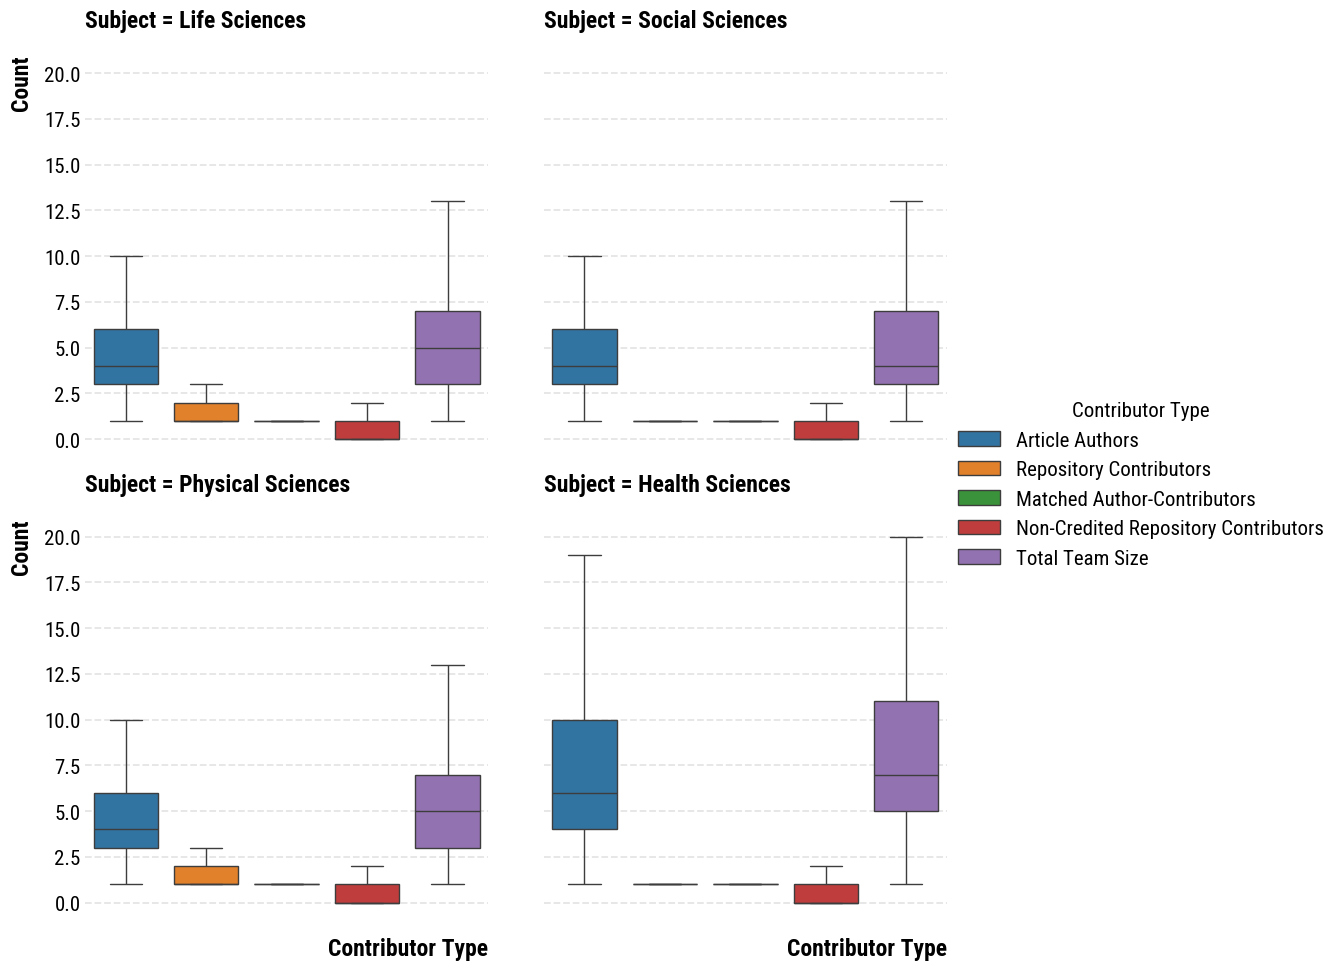

In [4]:
# Do the same thing but for each subject
g = sns.catplot(
    data=per_paper_counts_long_df,
    x="Contributor Type",
    y="Count",
    hue="Contributor Type",
    col="Subject",
    kind="box",
    showfliers=False,
    col_wrap=2,
    legend=True,
)

# Remove xlabels
for ax in g.axes.flat:
    ax.set_xticklabels([])

# Create dataframe of descriptive statistics
descriptive_stats = (
    per_paper_counts_df.groupby("Subject")
    .describe()
    .reset_index()
    .drop(columns=["document_id"])
    .T
)
descriptive_stats

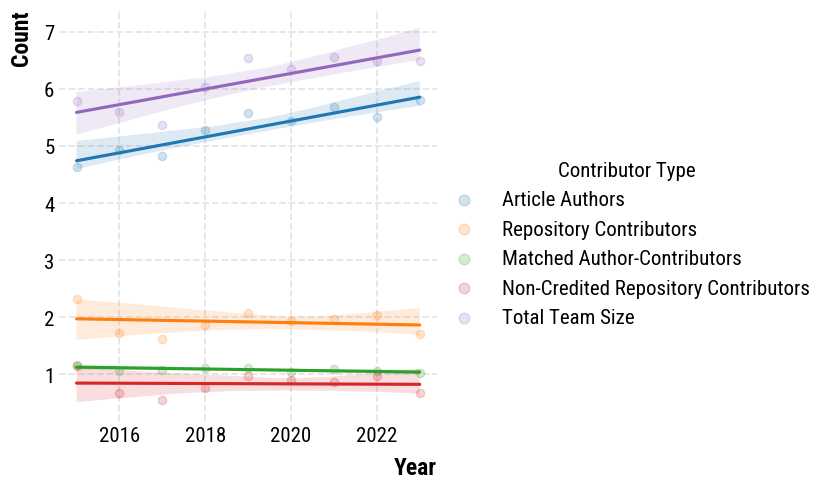

In [5]:
# Drop Discipline and groupby year take mean of metrics
all_subject_year_mean_metrics = (
    per_paper_counts_df.drop(
        columns=[
            "document_id",
            "Subject",
            "Document Citations",
            "Mean Normalized Document Citations",
        ],
    )
    .groupby("Year")
    .mean()
    .reset_index()
)
all_subject_year_mean_metrics = all_subject_year_mean_metrics.melt(
    id_vars=["Year"],
    var_name="Contributor Type",
    value_name="Count",
)

# Plot the metrics using seaborn lmplot
sns.lmplot(
    data=all_subject_year_mean_metrics,
    x="Year",
    y="Count",
    hue="Contributor Type",
    scatter_kws={"alpha": 0.2},
    ci=95,
)

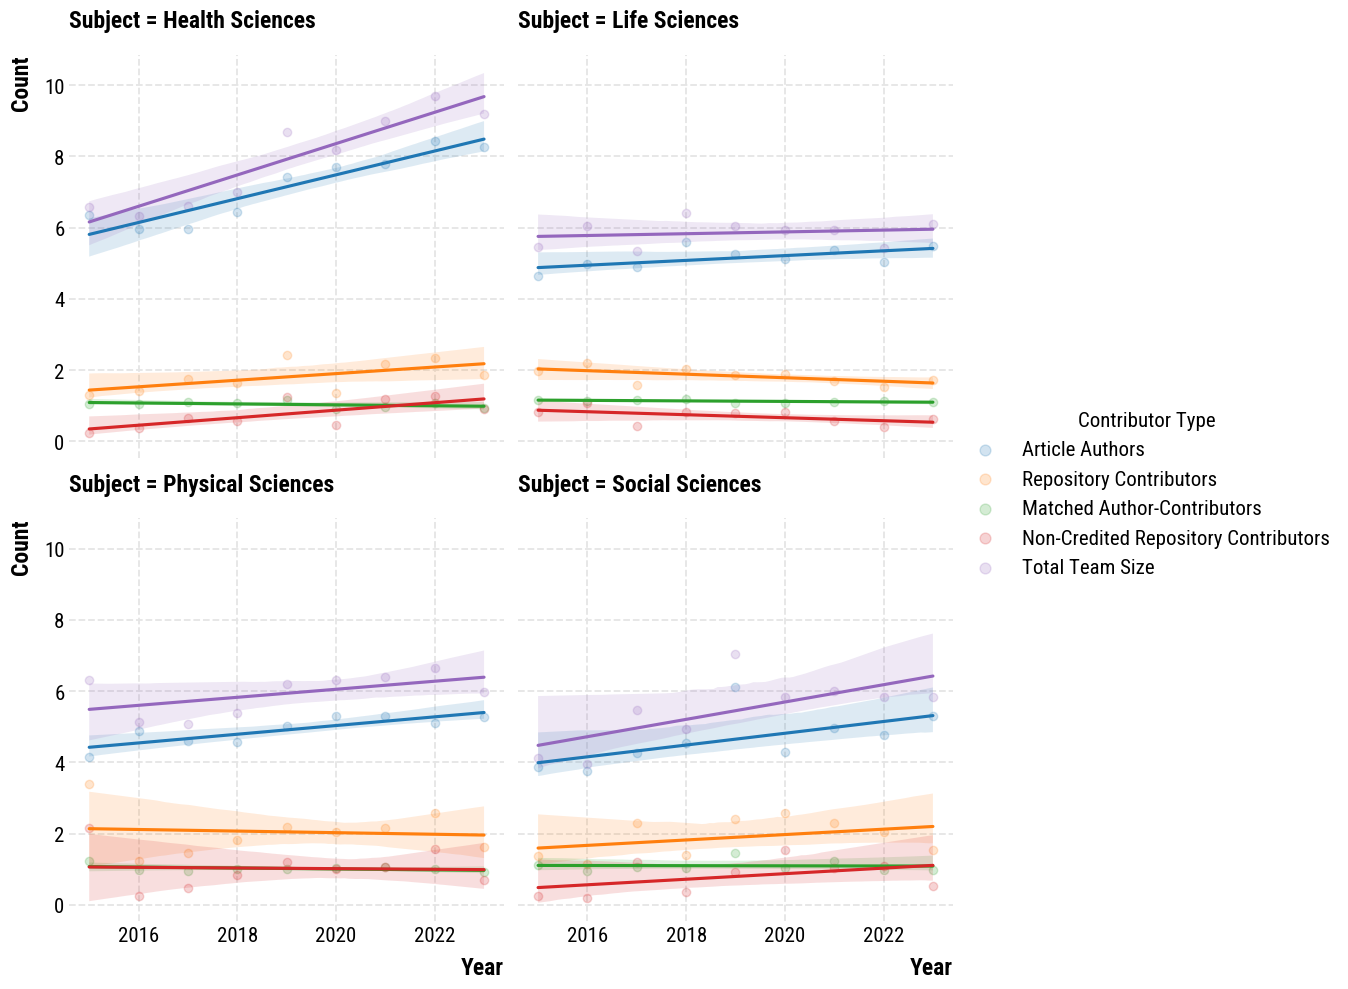

In [6]:
# Same thing but split by subject
# Drop document_id and groupby year take mean of metrics
subject_year_mean_metrics = (
    per_paper_counts_df.drop(
        columns=[
            "document_id",
            "Document Citations",
            "Mean Normalized Document Citations",
        ],
    )
    .groupby(["Subject", "Year"])
    .mean()
    .reset_index()
)

# Melt the dataframe to long format
subject_year_mean_metrics_long = subject_year_mean_metrics.melt(
    id_vars=["Subject", "Year"],
    var_name="Contributor Type",
    value_name="Count",
)

# Plot the metrics using seaborn lmplot
sns.lmplot(
    data=subject_year_mean_metrics_long,
    x="Year",
    y="Count",
    hue="Contributor Type",
    col="Subject",
    scatter_kws={"alpha": 0.2},
    ci=95,
    col_wrap=2,
)

### Separating Authorship and Contributorship

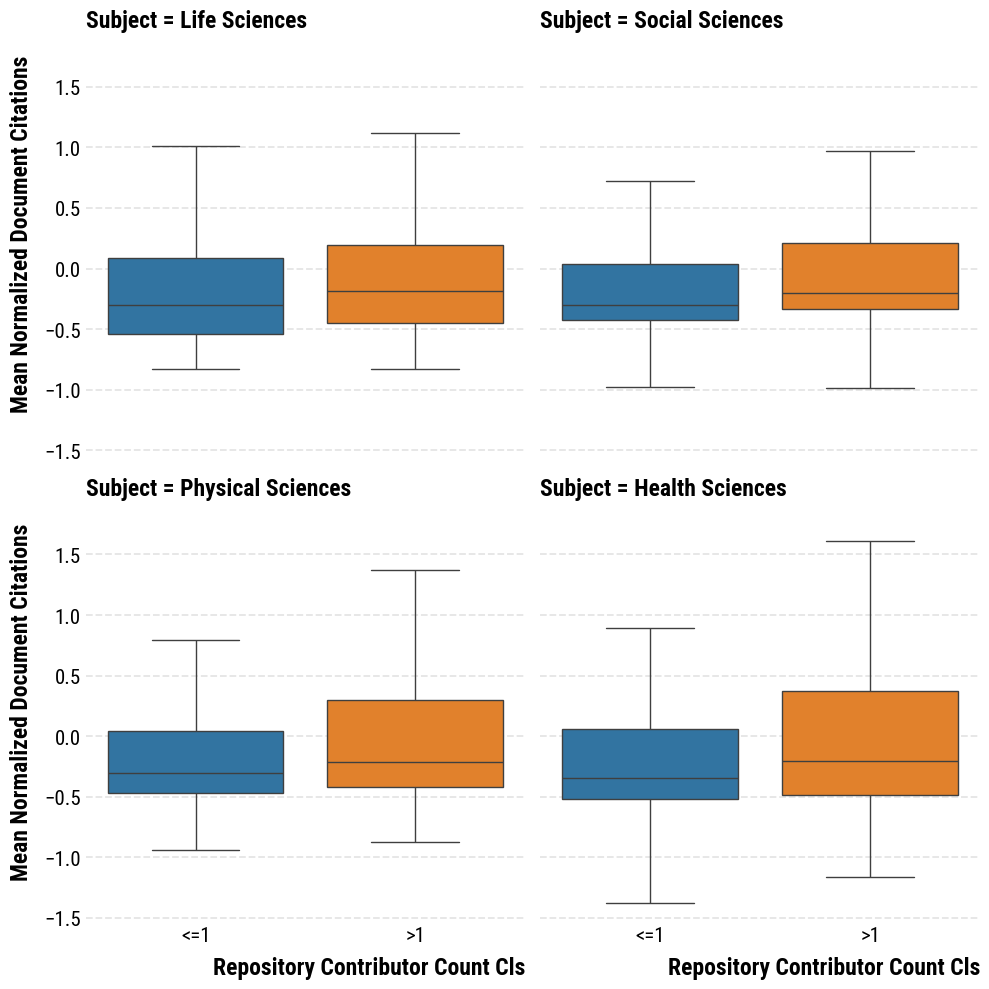

In [7]:
# Make contributor counts categorical
per_paper_counts_df["Repository Contributor Count Cls"] = per_paper_counts_df[
    "Repository Contributors"
].apply(lambda x: "<=1" if x < 2 else ">1")
per_paper_counts_df["Matched Author-Contributors Count Cls"] = per_paper_counts_df[
    "Matched Author-Contributors"
].apply(lambda x: "<=1" if x < 2 else ">1")

# Create boxplots for each group
sns.catplot(
    data=per_paper_counts_df,
    x="Repository Contributor Count Cls",
    y="Mean Normalized Document Citations",
    hue="Repository Contributor Count Cls",
    col="Subject",
    col_wrap=2,
    kind="box",
    showfliers=False,
)

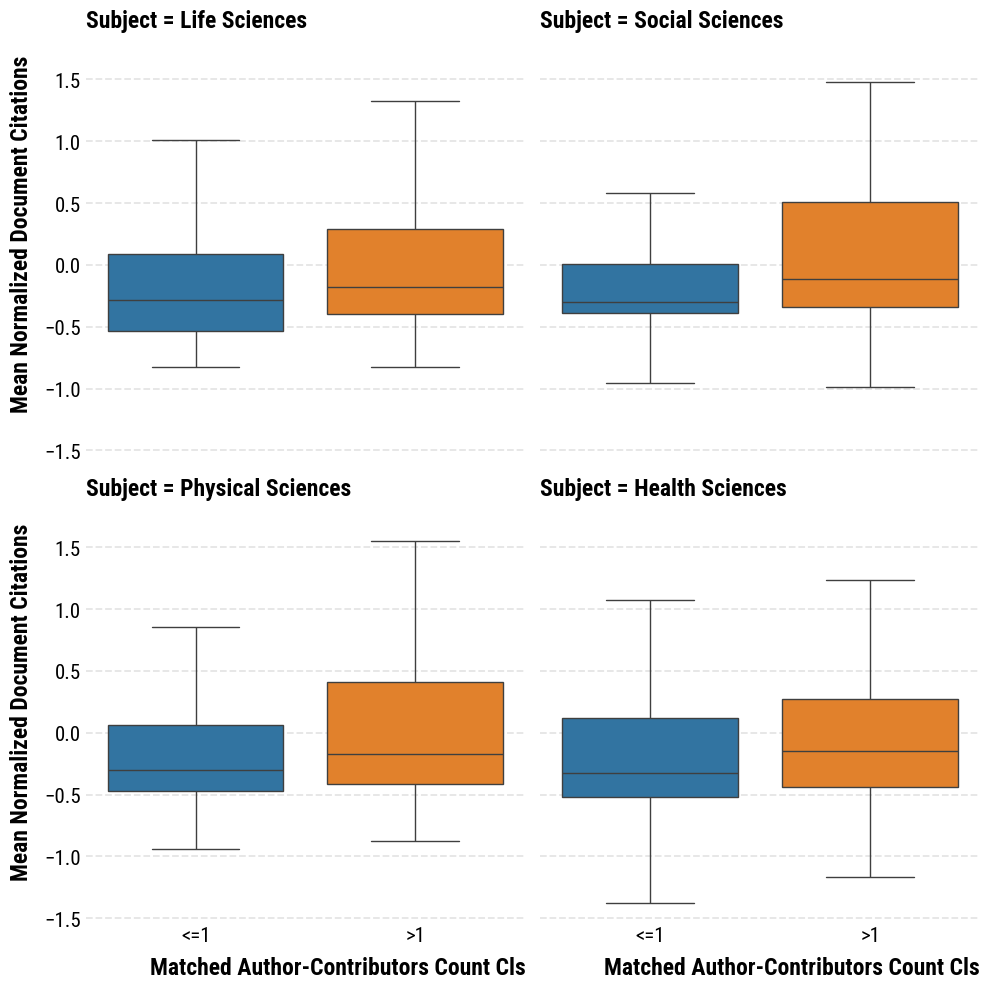

In [8]:
# Create boxplots for each group
sns.catplot(
    data=per_paper_counts_df,
    x="Matched Author-Contributors Count Cls",
    y="Mean Normalized Document Citations",
    hue="Matched Author-Contributors Count Cls",
    col="Subject",
    col_wrap=2,
    kind="box",
    showfliers=False,
)

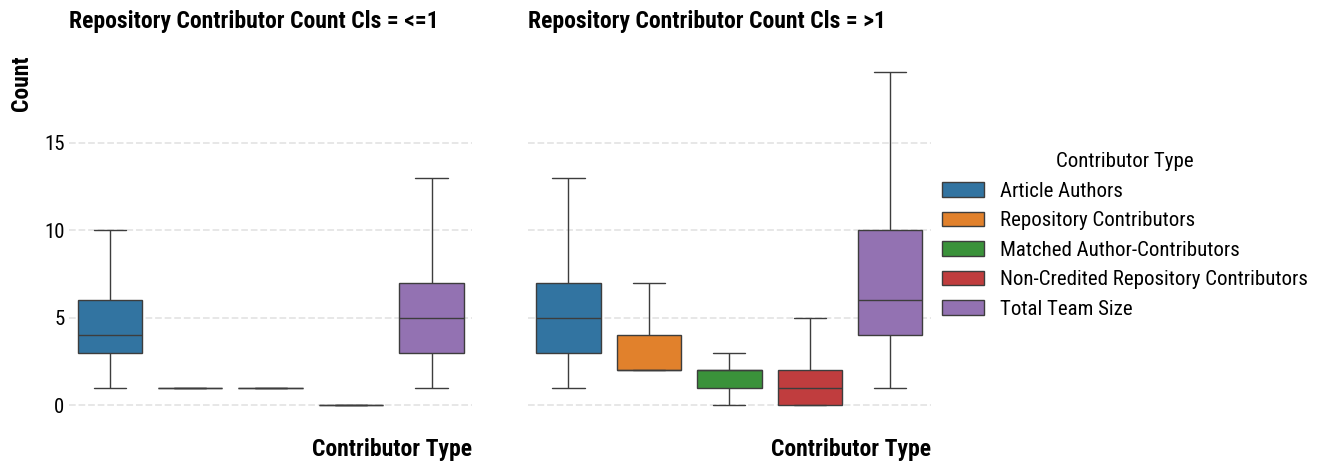

In [9]:
# Make long format
per_paper_counts_df_long = per_paper_counts_df.melt(
    id_vars=[
        "document_id",
        "Subject",
        "Year",
        "Document Citations",
        "Mean Normalized Document Citations",
        "Repository Contributor Count Cls",
        "Matched Author-Contributors Count Cls",
    ],
    value_vars=[
        "Article Authors",
        "Repository Contributors",
        "Matched Author-Contributors",
        "Non-Credited Repository Contributors",
        "Total Team Size",
    ],
    var_name="Contributor Type",
    value_name="Count",
)

# Plot boxplots
g = sns.catplot(
    data=per_paper_counts_df_long,
    x="Contributor Type",
    y="Count",
    hue="Contributor Type",
    col="Repository Contributor Count Cls",
    col_wrap=2,
    kind="box",
    showfliers=False,
    legend=True,
)

# Remove xlabels
for ax in g.axes.flat:
    ax.set_xticklabels([])

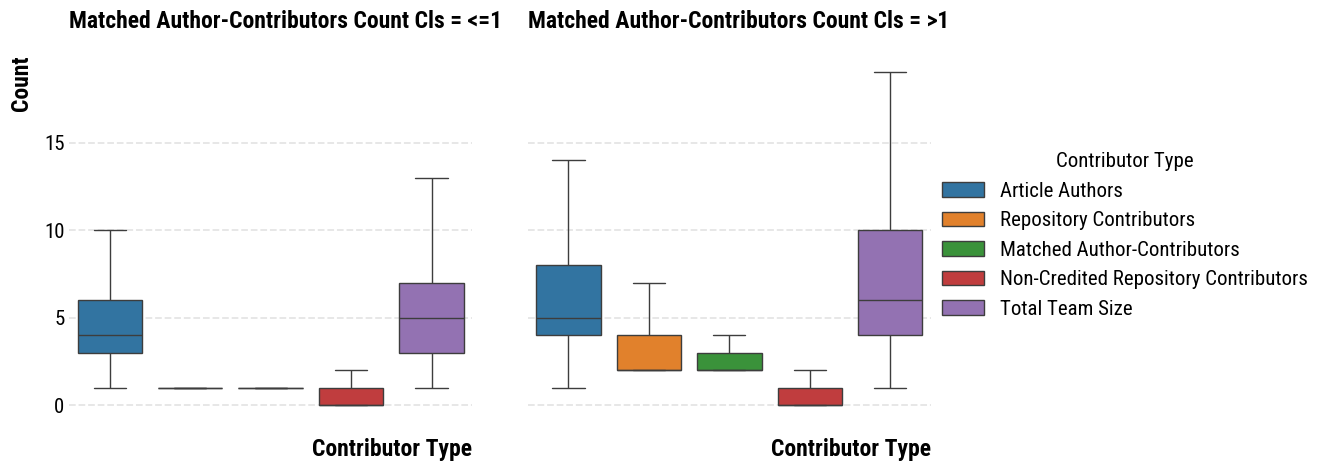

In [10]:
# Plot boxplots
g = sns.catplot(
    data=per_paper_counts_df_long,
    x="Contributor Type",
    y="Count",
    hue="Contributor Type",
    col="Matched Author-Contributors Count Cls",
    col_wrap=2,
    kind="box",
    showfliers=False,
    legend=True,
)

# Remove xlabels
for ax in g.axes.flat:
    ax.set_xticklabels([])

## Who are Developers

### Which Authors Are Developers?

,mean,std,min,25%,50%,75%,max
First Author Developers,0.763189,0.447941,0.0,1.0,1.0,1.0,2.0
Middle Author Developers,0.354625,0.816219,0.0,0.0,0.0,1.0,15.0
Last Author Developers,0.170097,0.375762,0.0,0.0,0.0,0.0,1.0
Corresponding Author Developers,0.847410,0.761499,0.0,0.0,1.0,1.0,14.0


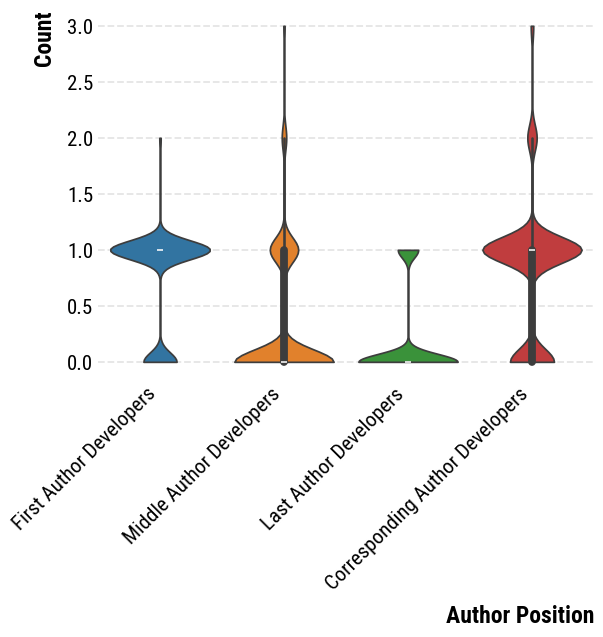

In [11]:
# Create dataframe so we can determine where developers lie in the whole team (by how common they are across all papers)
# Options include: "first author", "middle author", "last author", and "corresponding author"
# Specifically we want a dataframe with:
# "document_id",
# "Subject",
# "Year",
# "First Author Developers",
# "Middle Author Developers",
# "Last Author Developers",
# "Corresponding Author Developers",
# "Total Authors",
# "Document Citations",

per_paper_author_dev_contributors = []
for _, row in linked_doc_repos_df.iterrows():
    # Get subject
    subject = doc_fields_df.loc[
        doc_fields_df["document_id"] == row["document_id"]
    ].iloc[0]["topic_field_name"]

    # Get matching doc contributors
    doc_contributors = doc_contributors_df.loc[
        doc_contributors_df["document_id"] == row["document_id"]
    ]

    # Get matching repo contributors
    repo_contributors = repo_contributors_df.loc[
        repo_contributors_df["repository_id"] == row["repository_id"]
    ]

    # Get matching matched contributors
    matched_contributors = matched_contributors_df.loc[
        (
            matched_contributors_df["researcher_id"].isin(
                doc_contributors["researcher_id"]
            )
        )
        & (
            matched_contributors_df["developer_account_id"].isin(
                repo_contributors["developer_account_id"]
            )
        )
    ]
    if any(
        [
            len(doc_contributors) <= 1,
            len(repo_contributors) == 0,
            len(matched_contributors) == 0,
        ]
    ):
        continue

    # Keep track of counts
    first_author_devs = 0
    middle_author_devs = 0
    last_author_devs = 0
    corresponding_author_devs = 0

    for _, matched_contrib in matched_contributors.iterrows():
        # Get the position of the author
        author_details = doc_contributors.loc[
            doc_contributors["researcher_id"] == matched_contrib["researcher_id"]
        ].iloc[0]

        # Check position
        if author_details["document_researcher_position"] == "first":
            first_author_devs += 1
        elif author_details["document_researcher_position"] == "middle":
            middle_author_devs += 1
        elif author_details["document_researcher_position"] == "last":
            last_author_devs += 1

        # Check if corresponding author
        if author_details["document_researcher_is_corresponding"]:
            corresponding_author_devs += 1

    # If last author is greater than 1 then we have a problem
    if last_author_devs > 1:
        continue

    per_paper_author_dev_contributors.append(
        {
            "document_id": row["document_id"],
            "Subject": subject,
            "Year": row["document_publication_year"],
            "First Author Developers": first_author_devs,
            "Middle Author Developers": middle_author_devs,
            "Last Author Developers": last_author_devs,
            "Corresponding Author Developers": corresponding_author_devs,
            "Total Authors": len(doc_contributors),
            "Document Citations": row["document_cited_by_count"],
        }
    )

# Convert to dataframe
per_paper_author_dev_contributors_df = pd.DataFrame(per_paper_author_dev_contributors)

# Melt the dataframe to long format
per_paper_author_dev_contributors_long_df = per_paper_author_dev_contributors_df.melt(
    id_vars=["document_id", "Subject", "Year", "Total Authors", "Document Citations"],
    value_vars=[
        "First Author Developers",
        "Middle Author Developers",
        "Last Author Developers",
        "Corresponding Author Developers",
    ],
    var_name="Author Position",
    value_name="Count",
)

# Remove top 0.3% of outliers
per_paper_author_dev_contributors_long_df = per_paper_author_dev_contributors_long_df[
    per_paper_author_dev_contributors_long_df["Count"]
    < per_paper_author_dev_contributors_long_df["Count"].quantile(0.997)
]

# Plot violinplots
sns.violinplot(
    data=per_paper_author_dev_contributors_long_df,
    x="Author Position",
    y="Count",
    hue="Author Position",
    hue_order=[
        "First Author Developers",
        "Middle Author Developers",
        "Last Author Developers",
        "Corresponding Author Developers",
    ],
    # showfliers=False,
    cut=0,
)
plt.xticks(rotation=45, ha="right")

# Get statistics overall
per_paper_author_dev_contributors_df.drop(
    columns=["document_id", "Subject", "Year", "Total Authors", "Document Citations"],
).describe().T.drop(columns=["count"])

/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_38266/288655137.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  per_paper_author_dev_contributors_df.groupby("Subject").describe().reset_index().drop(columns=["document_id", "Year", "Document Citations"]).T


0              1  \
Subject                                Health Sciences  Life Sciences   
First Author Developers         count            588.0         2002.0   
                                mean          0.688776        0.78022   
                                std           0.474289       0.439945   
                                min                0.0            0.0   
                                25%                0.0            1.0   
                                50%                1.0            1.0   
                                75%                1.0            1.0   
                                max                2.0            2.0   
Middle Author Developers        count            588.0         2002.0   
                                mean          0.369048       0.332168   
                                std           0.711211       0.802952   
                                min                0.0            0.0   
                                25%                0.0            0.0   
                                50%                0.0            0.0   
                                75%                1.0            0.0   
                                max                8.0           13.0   
Last Author Developers          count            588.0         2002.0   
                                mean          0.161565       0.191309   
                                std           0.368364        0.39343   
                                min                0.0            0.0   
                                25%                0.0            0.0   
                                50%                0.0            0.0   
                                75%                0.0            0.0   
                                max                1.0            1.0   
Corresponding Author Developers count            588.0         2002.0   
                                mean          0.826531       0.829171   
                                std           0.626374       0.782612   
                                min                0.0            0.0   
                                25%                0.0            0.0   
                                50%                1.0            1.0   
                                75%                1.0            1.0   
                                max                5.0           14.0   
Total Authors                   count            588.0         2002.0   
                                mean          7.989796       5.309191   
                                std           5.551054       3.638981   
                                min                2.0            2.0   
                                25%                4.0            3.0   
                                50%                6.0            4.0   
                                75%               10.0            6.0   
                                max               40.0           44.0   

                                                       2                3  
Subject                                Physical Sciences  Social Sciences  
First Author Developers         count             1232.0            405.0  
                                mean            0.779221         0.738272  
                                std             0.445164         0.445708  
                                min                  0.0              0.0  
                                25%                  1.0              0.0  
                                50%                  1.0              1.0  
                                75%                  1.0              1.0  
                                max                  2.0              2.0  
Middle Author Developers        count             1232.0            405.0  
                                mean            0.358766         0.432099  
                                std             0.780252         1.084753 

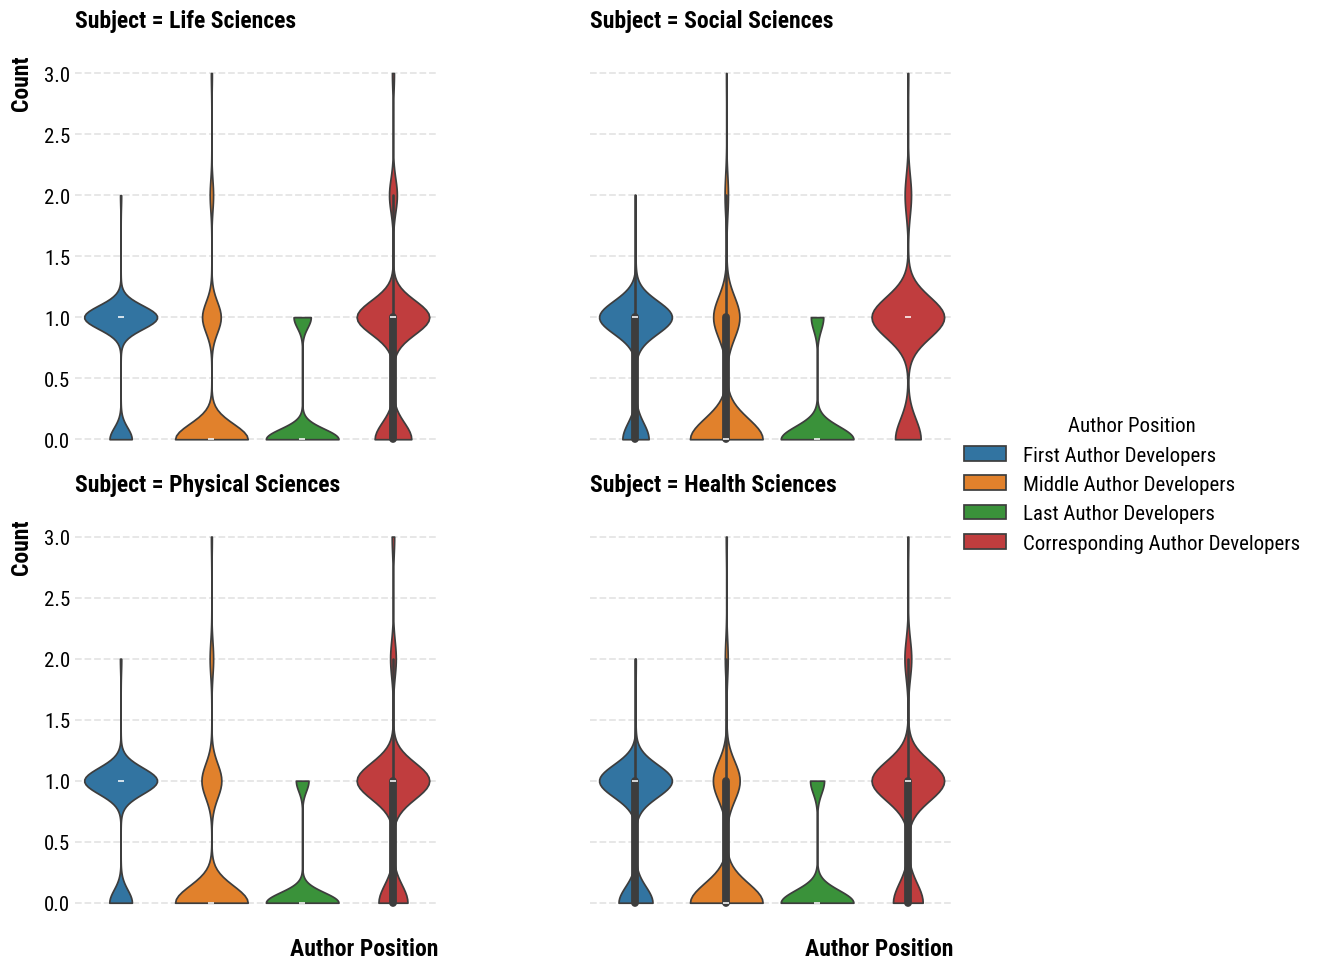

In [12]:
# Same thing split by subject
g = sns.catplot(
    data=per_paper_author_dev_contributors_long_df,
    x="Author Position",
    y="Count",
    hue="Author Position",
    col="Subject",
    kind="violin",
    cut=0,
    col_wrap=2,
    legend=True,
)

# Remove xlabels
for ax in g.axes.flat:
    ax.set_xticklabels([])

# Create dataframe of descriptive statistics
descriptive_stats = (
    per_paper_author_dev_contributors_df.groupby("Subject")
    .describe()
    .reset_index()
    .drop(columns=["document_id", "Year", "Document Citations"])
    .T
)
descriptive_stats

### Career Status of Developers

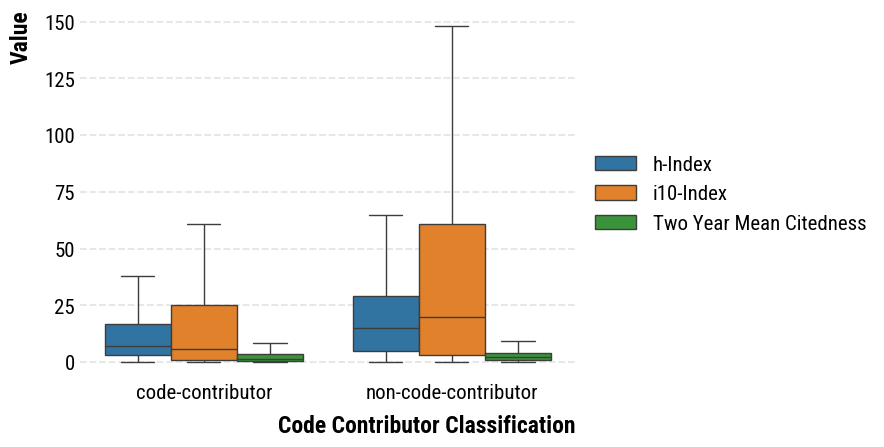

In [16]:
# Create a new dataframe that is the merge of:
# doc_contributors_df, matched_contributors_df, and doc_fields_df
# This will allow us to see author metrics
# attached to known developers and split by field

# Create a copy that is a subset of doc_contributors_df
code_doc_contribs_df = doc_contributors_df.copy()

# If the researcher_id is in matched_contributors_df then they are a code contributor
code_doc_contribs_df["code_contributor_cls"] = code_doc_contribs_df[
    "researcher_id"
].isin(matched_contributors_df["researcher_id"])

# Replace with string
code_doc_contribs_df["code_contributor_cls"] = code_doc_contribs_df[
    "code_contributor_cls"
].replace(
    {
        True: "code-contributor",
        False: "non-code-contributor",
    }
)

# Merge code_doc_contribs_df and doc_fields_df
code_doc_contribs_df = pd.merge(
    code_doc_contribs_df,
    doc_fields_df,
    how="inner",
    left_on="document_id",
    right_on="document_id",
)

# Select columns and the fields we want to use
matched_doc_contribs_df = (
    code_doc_contribs_df.groupby(
        "researcher_id",
    )
    .agg(
        {
            "code_contributor_cls": "first",
            # "researcher_works_count": "first",
            # "researcher_cited_by_count": "first",
            "researcher_h_index": "first",
            "researcher_i10_index": "first",
            "researcher_two_year_mean_citedness": "first",
            "topic_field_name": lambda x: x.mode()[0],
        }
    )
    .reset_index()
)

# Rename columns
matched_doc_contribs_df = matched_doc_contribs_df.rename(
    columns={
        "code_contributor_cls": "Code Contributor Classification",
        # "researcher_works_count": "Articles",
        # "researcher_cited_by_count": "Total Citations",
        "researcher_h_index": "h-Index",
        "researcher_i10_index": "i10-Index",
        "researcher_two_year_mean_citedness": "Two Year Mean Citedness",
        "topic_field_name": "Subject",
    }
)

# Make long format
matched_doc_contribs_df_long = matched_doc_contribs_df.melt(
    id_vars=["researcher_id", "Subject", "Code Contributor Classification"],
    var_name="Metric",
    value_name="Value",
)

# Make boxplot
sns.boxplot(
    matched_doc_contribs_df_long,
    hue="Metric",
    y="Value",
    x="Code Contributor Classification",
    showfliers=False,
    legend=True,
)

# Move legend outside to middle right
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

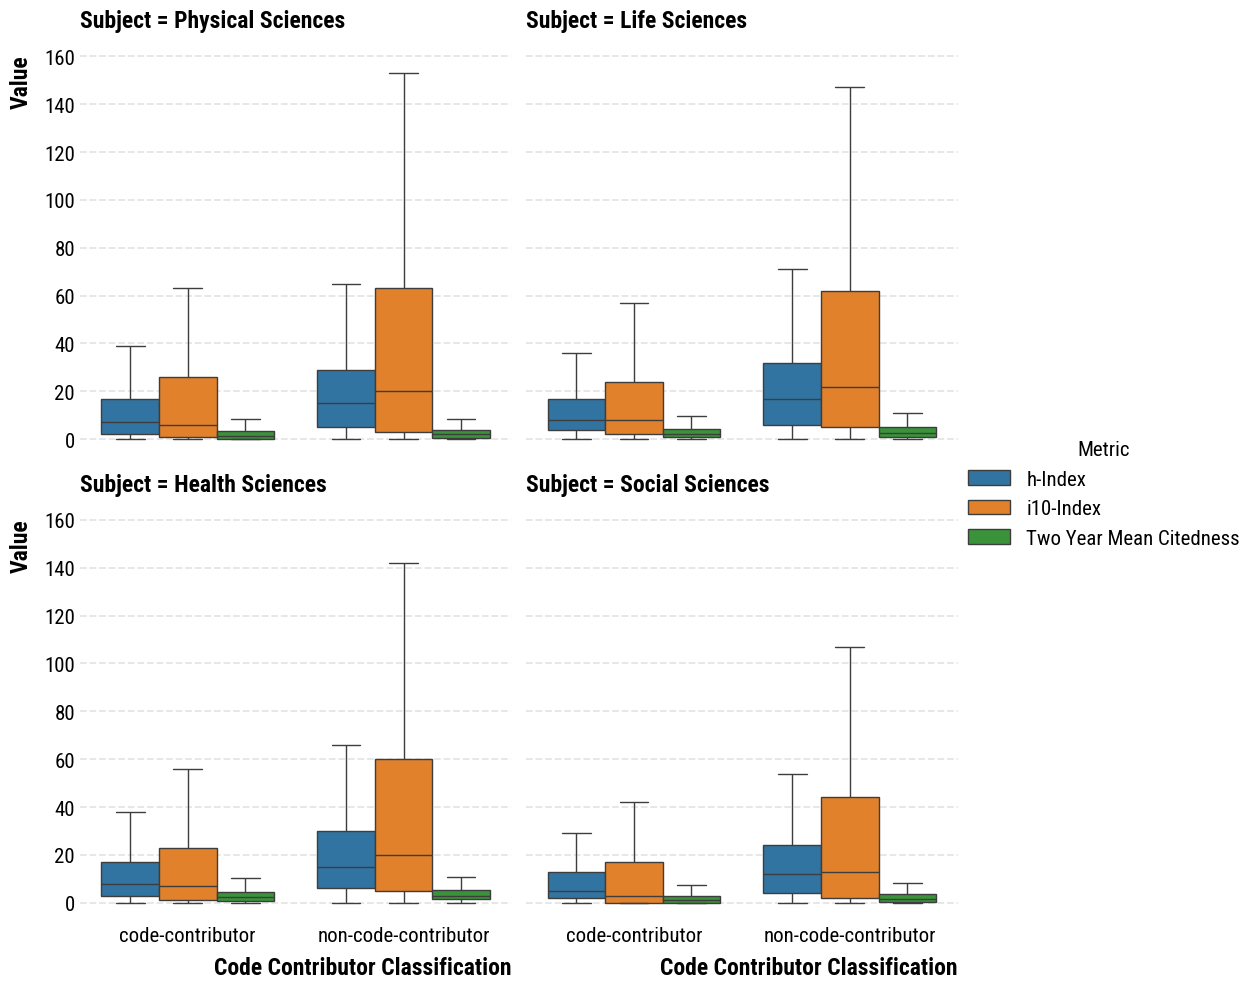

In [17]:
# Plot violinplots
sns.catplot(
    data=matched_doc_contribs_df_long,
    x="Code Contributor Classification",
    y="Value",
    hue="Metric",
    col="Subject",
    col_wrap=2,
    kind="box",
    # cut=0,
    showfliers=False,
    legend=True,
)

In [18]:
# T-tests for each metric
for metric in matched_doc_contribs_df_long["Metric"].unique():
    code_contribs = matched_doc_contribs_df_long.loc[
        (matched_doc_contribs_df_long["Metric"] == metric)
        & (
            matched_doc_contribs_df_long["Code Contributor Classification"]
            == "code-contributor"
        )
    ]["Value"]
    non_code_contribs = matched_doc_contribs_df_long.loc[
        (matched_doc_contribs_df_long["Metric"] == metric)
        & (
            matched_doc_contribs_df_long["Code Contributor Classification"]
            == "non-code-contributor"
        )
    ]["Value"]

    ttest_result = ttest_ind(code_contribs, non_code_contribs)
    ci = ttest_result.confidence_interval()
    print(
        f"Metric: {metric}, "
        f"t-statistic: {ttest_result.statistic}, "
        f"p-value: {ttest_result.pvalue}, "
        f"ci-low: {ci.low} ci-high: {ci.high}"
    )

Metric: h-Index, t-statistic: -48.47334021458197, p-value: 0.0, ci-low: -7.575277058348423 ci-high: -6.9864814526418435
Metric: i10-Index, t-statistic: -3.2544918904935844, p-value: 0.0011363553087131118, ci-low: -8.874352281391614 ci-high: -2.2030711165322665
Metric: Two Year Mean Citedness, t-statistic: -3.380955718752313, p-value: 0.0007226356896990536, ci-low: -0.5652470135444446 ci-high: -0.15038482490619778
